Displacement data can be found in RIOT

## Load the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import xgboost as xgb
import tensorflow.keras
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics

## Load the data

In [2]:
prec = pd.read_csv('../data/timeseries_derived_data_products/MH25_vaisalawxt520prec_2017.csv', parse_dates=['time'])
wind = pd.read_csv('../data/timeseries_derived_data_products/MH25_vaisalawxt520windpth_2017.csv', parse_dates=['time'])
temp = pd.read_csv('../data/timeseries_derived_data_products/MH30_temperature_rock_2017.csv', parse_dates=['time'])
radio = pd.read_csv('../data/timeseries_derived_data_products/MH15_radiometer__conv_2017.csv', parse_dates=['time'])
displ = pd.read_csv('../data/MH8_displacement_2017_processed.csv')

In [3]:
displ = displ[['timed','displacement_dx1']]

In [4]:
displ = displ.set_index(displ['timed'])

In [5]:
displ.index = pd.to_datetime(displ.index, utc=True)

In [6]:
displ = displ.resample('60Min', how='mean', base=0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


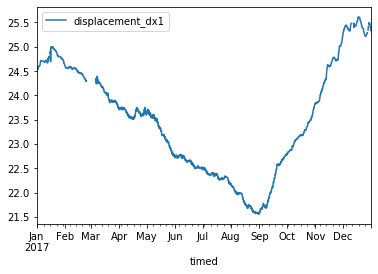

In [7]:
displ.plot()
plt.show()

In [8]:
displ = displ.dropna()

## Merge the datasets

In [9]:
temp_inner = pd.merge(left= temp, right=prec, left_on='time',right_on='time')
temp_inner = pd.merge(left= temp_inner, right=wind, left_on='time',right_on='time')
temp_inner = pd.merge(left=temp_inner, right=radio, left_on='time',right_on='time')
temp_inner = pd.merge(left=temp_inner, right=displ, left_on='time',right_on='timed')

## Select Columns

In [10]:
temp_inner['time'] = pd.to_datetime(temp_inner['time'])
temp_inner['season'] = np.round(pd.DatetimeIndex(temp_inner['time']).month/3)
del temp_inner['time']

temp_inner = temp_inner[['temperature_5cm [°C]', 'temperature_10cm [°C]',
       'temperature_20cm [°C]', 'temperature_30cm [°C]',
       'temperature_50cm [°C]', 'temperature_100cm [°C]',
       'wind_speed_average [km/h]', 'net_radiation [Wm^-2]', 'season','displacement_dx1']]

temp_inner.dropna()

,temperature_5cm [°C],temperature_10cm [°C],temperature_20cm [°C],temperature_30cm [°C],temperature_50cm [°C],temperature_100cm [°C],wind_speed_average [km/h],net_radiation [Wm^-2],season,displacement_dx1
0,-9.4934,-9.1609,-8.7378,-8.4231,-7.9328,-7.1922,6.2129,-103.3271,0.0,24.508750
1,-9.5680,-9.2330,-8.8027,-8.4813,-7.9573,-7.2040,6.6033,-103.3083,0.0,24.509348
2,-9.6568,-9.3084,-8.8668,-8.5235,-7.9845,-7.2081,7.8323,-102.9365,0.0,24.509739
3,-9.7203,-9.3797,-8.9384,-8.5756,-8.0103,-7.2166,8.9094,-101.0145,0.0,24.511487
4,-9.7547,-9.4270,-8.9953,-8.6287,-8.0473,-7.2120,10.2742,-101.7435,0.0,24.513250
...,...,...,...,...,...,...,...,...,...,...
8224,-7.6313,-7.7113,-8.0290,-8.6597,-9.8506,-11.1339,14.4031,-94.8729,4.0,25.323352
8225,-7.8590,-7.9045,-8.1471,-8.6852,-9.7932,-11.0855,14.5226,-90.9528,4.0,25.323617
8226,-8.0373,-8.0760,-8.2650,-8.7243,-9.7447,-11.0400,17.6968,-85.6891,4.0,25.325616
8227,-8.2845,-8.2529,-8.3710,-8.7687,-9.7071,-10.9868,13.8333,-88.2355,4.0,25.328565


##  Create the target

In [11]:
lag = -1
#diff = temp_inner['temperature_100cm [°C]'] - temp_inner['temperature_5cm [°C]']
#temp_inner.insert(0, 'delta_t', diff)


# shift 
temp_inner['displacement_dx1'] = temp_inner['displacement_dx1'].shift(lag)
temp_inner = temp_inner.drop(temp_inner.index[temp_inner.shape[0] : temp_inner.shape[0] + lag])
temp_inner = temp_inner.replace(np.nan, 0)
temp_inner.head()

,temperature_5cm [°C],temperature_10cm [°C],temperature_20cm [°C],temperature_30cm [°C],temperature_50cm [°C],temperature_100cm [°C],wind_speed_average [km/h],net_radiation [Wm^-2],season,displacement_dx1
0,-9.4934,-9.1609,-8.7378,-8.4231,-7.9328,-7.1922,6.2129,-103.3271,0.0,24.509348
1,-9.5680,-9.2330,-8.8027,-8.4813,-7.9573,-7.2040,6.6033,-103.3083,0.0,24.509739
2,-9.6568,-9.3084,-8.8668,-8.5235,-7.9845,-7.2081,7.8323,-102.9365,0.0,24.511487
3,-9.7203,-9.3797,-8.9384,-8.5756,-8.0103,-7.2166,8.9094,-101.0145,0.0,24.513250
4,-9.7547,-9.4270,-8.9953,-8.6287,-8.0473,-7.2120,10.2742,-101.7435,0.0,24.515465


## Train test split

In [12]:
X, y = temp_inner.drop(['displacement_dx1'], axis=1), temp_inner['displacement_dx1']

In [13]:
# split train and validation data
validation_fraction = 0.2
validation_first = False


val_size = int(validation_fraction * X.shape[0])
train_size = X.shape[0] - val_size

if validation_first:
    X_train, X_val = Y[val_size:], X[:val_size]
    y_train, y_val = y[val_size:], y[:val_size]
    
else:
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]


In [16]:
X_val[-10:]

,temperature_5cm [°C],temperature_10cm [°C],temperature_20cm [°C],temperature_30cm [°C],temperature_50cm [°C],temperature_100cm [°C],wind_speed_average [km/h],net_radiation [Wm^-2],season
8219,-5.9159,-6.6131,-7.8184,-8.9634,-10.3381,-11.3975,12.4871,-87.1849,4.0
8220,-6.1581,-6.6884,-7.7403,-8.7826,-10.2300,-11.3284,15.1067,-86.6400,4.0
8221,-6.5924,-6.9188,-7.7315,-8.6855,-10.1106,-11.2736,17.5258,-99.1272,4.0
8222,-6.9997,-7.1883,-7.8033,-8.6500,-10.0187,-11.2287,11.5290,-92.9561,4.0
8223,-7.3434,-7.4478,-7.9041,-8.6388,-9.9316,-11.1834,11.7355,-96.2305,4.0
8224,-7.6313,-7.7113,-8.0290,-8.6597,-9.8506,-11.1339,14.4031,-94.8729,4.0
8225,-7.8590,-7.9045,-8.1471,-8.6852,-9.7932,-11.0855,14.5226,-90.9528,4.0
8226,-8.0373,-8.0760,-8.2650,-8.7243,-9.7447,-11.0400,17.6968,-85.6891,4.0
8227,-8.2845,-8.2529,-8.3710,-8.7687,-9.7071,-10.9868,13.8333,-88.2355,4.0
8228,-8.6132,-8.4832,-8.5223,-8.8365,-9.6687,-10.9526,14.4219,-87.2561,4.0


## Data Standartization

In [17]:
#Y_MEAN, Y_STD = y_train.mean(), y_train.std()

#y_train = (y_train - Y_MEAN)/Y_STD
#y_val   = (y_val -   Y_MEAN)/Y_STD
#X_MEAN, X_STD = X_train.mean(), X_train.std()
#X_train = (X_train - X_MEAN)/X_STD
#X_val = (X_val - X_MEAN)/X_STD

In [18]:
input_shape = X_train.shape
n_units = 80
n_layers = 3
n_frames = 5 # length of autoregressive sequence

In [19]:
input_shape

(6584, 9)

## Define the LSTM model

In [20]:
from tensorflow.keras import layers, models
i = layers.Input(shape = (n_frames, 9)) # (?, n_frames, channels) 

# add the lstm layers
x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(i) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=False)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
#n_units *= 2            

#x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Activation('relu')(x)

o = layers.Dense(1, activation = 'linear')(x)

In [21]:
model = models.Model(inputs=[i], outputs=[o])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 9)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 80)             28800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 160)            154240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 320)            615680    
_________________________________________________________________
lstm_3 (LSTM)                (None, 640)               2460160   
_________________________________________________________________
dense (Dense)                (None, 128)               82048     
_________________________________________________________________
activation (Activation)      (None, 128)               0     

In [23]:
from tensorflow.keras import optimizers, losses, metrics
    
model.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss=losses.mse)
              #metrics=[metrics.mse])

In [24]:
from tensorflow.keras import utils
class SequenceGenerator(utils.Sequence):
    '''Generates image sequences'''

    def __init__(self, data, labels, batch_size=32, n_frames=5):
        '''Initialization'''
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.n_frames = n_frames

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        '''Generate one batch of data'''

        batch_x, batch_y = [], []

        for _ in range(self.batch_size):
            # Get start index of sequence
            start_index = np.random.randint(0, len(self.data) - self.n_frames)
            stop_index = start_index + self.n_frames

            # x = image sequence
            x = self.data[start_index:stop_index].values
            # y = streamflow at end point
            y = self.labels[stop_index]
            batch_x.append(x)
            batch_y.append(y)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        return batch_x, batch_y


In [25]:
batch_size = 120
n_epochs = 5
generator_train = SequenceGenerator(data = X_train, labels = y_train, batch_size = batch_size, n_frames = n_frames)
generator_test = SequenceGenerator(data = X_val, labels = y_val, batch_size = batch_size, n_frames = n_frames)

## Train the model

In [ ]:
history = model.fit_generator(generator = generator_train,
                              steps_per_epoch = len(X_train)//batch_size,
                              epochs = n_epochs)

Epoch 1/5
54/54 [==============================] - 86s 2s/step - loss: 73.7284
Epoch 2/5
54/54 [==============================] - 83s 2s/step - loss: 0.8246
Epoch 3/5
16/54 [=======>......................] - ETA: 1:06 - loss: 0.6836

In [ ]:
plt.plot(history.history['loss'])

## Test on validation set

In [ ]:
predictions = []
y_truth = []
for t in range(0, len(X_val)-n_frames):
    start_index = t
    stop_index = start_index + n_frames
    data = X_val[start_index : stop_index].values
    data = data[np.newaxis, ...]
    p = np.asscalar(model.predict( data))
    # p = p * y_std + y_mean
    predictions.append(p)
    y_truth.append(y_val.iloc[stop_index])

In [ ]:
pd.concat([pd.DataFrame(y_truth, columns=['True']), 
           pd.DataFrame(predictions, columns = ["Predicted"])], axis = 1).plot(figsize=(12,5))

In [ ]:
rmse = np.sqrt(metrics.mean_squared_error(y_truth, predictions))
print("The RMSE is " + str(rmse))

In [32]:
y_truth[-10:]

[25.323916129032252,
 25.322978125000002,
 25.324040000000004,
 25.323900000000002,
 25.32335161290322,
 25.32361666666667,
 25.32561612903225,
 25.328564516129035,
 25.33412258064517,
 0.0]

In [33]:
y_val[-10:]

8219    25.323916
8220    25.322978
8221    25.324040
8222    25.323900
8223    25.323352
8224    25.323617
8225    25.325616
8226    25.328565
8227    25.334123
8228     0.000000
Name: displacement_dx1, dtype: float64